In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import imagehash
from PIL import Image

import sys 
import os
from pathlib import Path

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [2]:
# To get the type of cats all we need to do is see how many folders we have in the data directory, since they are already classified.

entries = os.listdir('./data')
print(f'{len(entries)} types of cats')
# We see that we have 3 types of cats

7 types of cats


In [3]:
# To see how many images we have of each we have to iterate trough each folder... I will use Path from pathlib for this.
folder_images = {}
parent_dir = Path('./data')
for subfolder in parent_dir.iterdir():
    if subfolder.is_dir():
        folder_images[subfolder.name] = len(list(subfolder.glob('*.jpg')))

folder_images

{'african-wildcat': 91,
 'blackfoot-cat': 79,
 'chinese-mountain-cat': 42,
 'domestic-cat': 64,
 'european-wildcat': 85,
 'jungle-cat': 86,
 'sand-cat': 72}

In [4]:
# To see the typical image size I will get all images and get the mean.
image_sizes = []
for subfolder in parent_dir.iterdir():
    if subfolder.is_dir():
        for image in subfolder.glob('*.jpg'):
            img = plt.imread(image)
            # Convert to from bytes to kilobytes
            image_sizes.append(img.nbytes / 1024)
# Now we get the mean
np.mean(image_sizes)
# Since the outliers are quite big, we can remove them to get a more realistic mean.
image_sizes_cleaned = [size for size in image_sizes if size >= 10000]
np.mean(image_sizes_cleaned)

# Hm, the size amount seems to be quite a lot bigger than the amounts i see in File Expolorer. Wonder why that it.
# After a little research I found that File Explorer shows compressed file sizes, so when we load images in python it gets decompressed into the full array, that's why we see a difference.

np.float64(28696.638427734375)

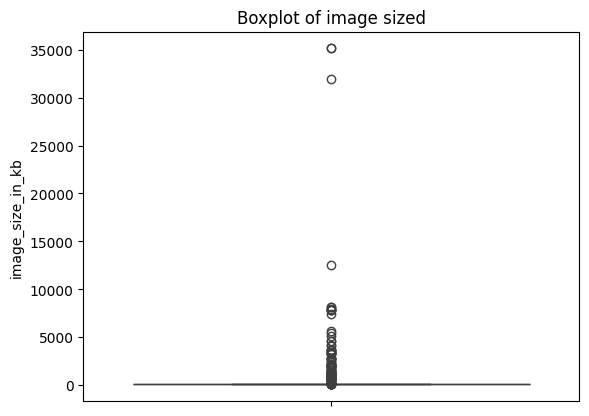

In [5]:
# Now.. to get the outliers, I will create a DataFrame with the image sizes and then use seaborn to visualize it.
image_sizes = pd.DataFrame(image_sizes, columns=['image_size_in_kb'])
sns.boxplot(image_sizes['image_size_in_kb'])
plt.title("Boxplot of image sized")
plt.show()

# We see that we have some outliers, if it was up to me, I'd say anything above 10000kb is an outlier in this case. Which would mean we have 3 outliers.

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [6]:
# Let's try using hashes...
def hash_file(filepath, algo='sha256'):
    hash_func = hashlib.new(algo)
    with open(filepath, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b''):
            hash_func.update(chunk)
    return hash_func.hexdigest()

def find_duplicate_images(folder_path):
    hashes = {}
    duplicates = []

    for folder in Path(folder_path).iterdir():
        if not folder.is_dir():
            continue
        for file in folder.glob('*.jpg'):
            file_hash = hash_file(file)
            if file_hash in hashes:
                duplicates.append((file, hashes[file_hash]))
            else:
                hashes[file_hash] = file

        return duplicates

duplicates = find_duplicate_images('./data')
duplicates # = []

# As I thought this wont work because no image is really the same, they all have different filters, watermarks, sizes,. etc.


[]

In [12]:
# We will need to change strategy. Let's use perceptual hashing instead, that way we can tell if how similar the pictures need to be, in order for us to consider them duplicates.
def find_similar_images(folder_path, hashfunc=imagehash.phash, treshold = 5):
    hashes = {}
    duplicates = []

    for folder in Path(folder_path).iterdir():
        if not folder.is_dir():
            continue
        for file in folder.glob('*.jpg'):
            img = Image.open(file)
            img_hash = hashfunc(img)

            found_duplicates = False
            for h, f in hashes.items():
                if img_hash - h <= treshold:
                    duplicates.append((file.name, f.name))
                    found_duplicates = True
                    break
            if not found_duplicates:
                hashes[img_hash] = file
    
    return duplicates

dupes = find_similar_images('./data')
dupes

# Okay, this time it worked.
# The way perceptual hashing works is that the image is being converted ot an 8x8 array of bits. First rezied to 32x32 and then converted to grayscale. We are not looking for details,
# we are looking for the general shape of the image, so we can compare it to other images. The treshold is the amount of difference (in bits) we allow between images.
# My treshold of 5 means in those 64 bits we allot a difference of 5, which is approximately 7.8% difference.

[('af (32).jpg', 'af (27).jpg'),
 ('af (37).jpg', 'af (11).jpg'),
 ('af (47).jpg', 'af (13).jpg'),
 ('af (51).jpg', 'af (38).jpg'),
 ('af (61).jpg', 'af (50).jpg'),
 ('af (74).jpg', 'af (16).jpg'),
 ('af (76).jpg', 'af (56).jpg'),
 ('af (9).jpg', 'af (42).jpg'),
 ('bc (30).jpg', 'bc (24).jpg'),
 ('bc (53).jpg', 'bc (41).jpg'),
 ('bc (63).jpg', 'bc (5).jpg'),
 ('bc (79).jpg', 'bc (73).jpg'),
 ('bc (9).jpg', 'bc (55).jpg'),
 ('ch (20).jpg', 'ch (10).jpg'),
 ('ch (32).jpg', 'ch (29).jpg'),
 ('ch (39).jpg', 'ch (25).jpg'),
 ('ch (42).jpg', 'ch (13).jpg'),
 ('ch (8).jpg', 'ch (4).jpg'),
 ('ch (9).jpg', 'ch (26).jpg'),
 ('dc (27).jpg', 'dc (14).jpg'),
 ('dc (36).jpg', 'dc (14).jpg'),
 ('dc (42).jpg', 'dc (18).jpg'),
 ('dc (5).jpg', 'af (69).jpg'),
 ('dc (52).jpg', 'af (33).jpg'),
 ('dc (63).jpg', 'af (33).jpg'),
 ('eu (11).jpg', 'af (33).jpg'),
 ('eu (23).jpg', 'af (65).jpg'),
 ('eu (3).jpg', 'eu (26).jpg'),
 ('eu (32).jpg', 'af (85).jpg'),
 ('eu (33).jpg', 'af (29).jpg'),
 ('eu (38).jpg', '

In [ ]:
# Now to remove them we will simply tweak the function a little so it removes the file when it is a duplicate instead of adding it to our list.
def remove_similar_images(folder_path, hashfunc=imagehash.phash, treshold = 5):
    hashes = {}
    removed_files = []

    for folder in Path(folder_path).iterdir():
        if not folder.is_dir():
            continue
        for file in folder.glob('*.jpg'):
            img = Image.open(file)
            img_hash = hashfunc(img)

            found_duplicates = False
            for h, f in hashes.items():
                if img_hash - h <= treshold:
                    # Here is out change
                    os.remove(file)
                    removed_files.append(file.name)
                    found_duplicates = True
                    break
            if not found_duplicates:
                hashes[img_hash] = file
    
    return removed_files

removed_files = remove_similar_images('./data')
removed_files

# After removing duplicates I see that we still have some similar images (ones where we have a watermark below) which are not removed, so I will try to increase the treshold a little.
removed_files = remove_similar_images('./data', treshold=10)
removed_files

# Well, seems like perceptual hashing is not good enough to catch watermarks, I will try a different techinique in the future if I have time.

['af (66).jpg', 'ch (37).jpg', 'jg (12).jpg', 'sd (49).jpg']

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.